# Monkeypox Classificaton
Dataset Credits:  [Monkeypox Skin Lesion Dataset](https://www.kaggle.com/datasets/nafin59/monkeypox-skin-lesion-dataset)

### Import all the Dependencies

In [146]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Set all the Constants

In [147]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

### Import data into tensorflow dataset object
Generates a tf.data.Dataset from image files in a directory: 
[tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [148]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "Monkeypox/Fold1/Fold1/Fold1/Train",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2142 files belonging to 2 classes.


In [149]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "Monkeypox/Fold1/Fold1/Fold1/Val",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 420 files belonging to 2 classes.


In [150]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "Monkeypox/Fold1/Fold1/Fold1/Test",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 45 files belonging to 2 classes.


In [151]:
class_names = train_ds.class_names
class_names

['Monkeypox', 'Others']

In [152]:
len(train_ds)

67

In [153]:
len(val_ds)

14

In [154]:
len(test_ds)

2

In [155]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels.

### Visualize some of the images from our dataset

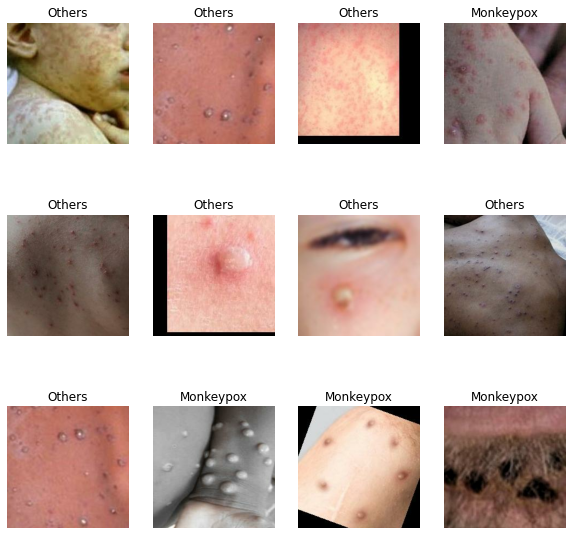

In [156]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Cache, Shuffle, and Prefetch the Dataset

In [157]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 224). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

Why do we need to resize (224,224) image to again (224,224)? We don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (224,224) and this layer will resize it.

In [158]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./224),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [159]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

You can read documentation on `Conv2D` Layer here: [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

`Sequential` provides training and inference features on this model: [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)

In [180]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    BatchNormalization(),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    BatchNormalization(),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

model1.build(input_shape=input_shape)

In [183]:
model1.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_28 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_200 (Conv2D)         (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_199 (MaxPooli  (32, 111, 111, 32)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_78 (Bat  (32, 111, 111, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_201 (Conv2D)         (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_200 (MaxPooli  (32, 54, 54, 64)       

### Compiling the Model
We use adam `Optimizer`, `BinaryCrossentropy` for losses, `accuracy` as a metric

In [184]:
model1.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=['accuracy']
)

In [185]:
history = model1.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
67/67 [==============================] - 55s 797ms/step - loss: 0.6605 - accuracy: 0.6246 - val_loss: 0.6796 - val_accuracy: 0.6238
Epoch 2/30
67/67 [==============================] - 56s 834ms/step - loss: 0.6105 - accuracy: 0.6783 - val_loss: 0.7381 - val_accuracy: 0.3786
Epoch 3/30
67/67 [==============================] - 59s 884ms/step - loss: 0.5646 - accuracy: 0.7110 - val_loss: 0.7003 - val_accuracy: 0.5190
Epoch 4/30
67/67 [==============================] - 54s 811ms/step - loss: 0.5156 - accuracy: 0.7624 - val_loss: 0.6739 - val_accuracy: 0.6500
Epoch 5/30
67/67 [==============================] - 53s 798ms/step - loss: 0.4514 - accuracy: 0.7866 - val_loss: 0.5568 - val_accuracy: 0.7214
Epoch 6/30
67/67 [==============================] - 54s 802ms/step - loss: 0.3988 - accuracy: 0.8235 - val_loss: 0.8532 - val_accuracy: 0.5833
Epoch 7/30
67/67 [==============================] - 54s 803ms/step - loss: 0.3498 - accuracy: 0.8529 - val_loss: 0.6364 - val_accuracy: 0.7000

In [186]:
scores = model1.evaluate(test_ds)

2/2 [==============================] - 0s 197ms/step - loss: 1.2310 - accuracy: 0.6889


we get 68% accuracy for our test dataset.

In [187]:
scores

[1.230973482131958, 0.6888889074325562]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [188]:
history

You can read documentation on history object here: [tf.keras.callbacks.History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)

In [189]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 67}

In [190]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [191]:
type(history.history['loss'])

list

In [192]:
len(history.history['loss'])

30

In [193]:
history.history['loss'][:5]

[0.6604764461517334,
 0.6104742288589478,
 0.5645626783370972,
 0.5155841112136841,
 0.45141690969467163]

In [194]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

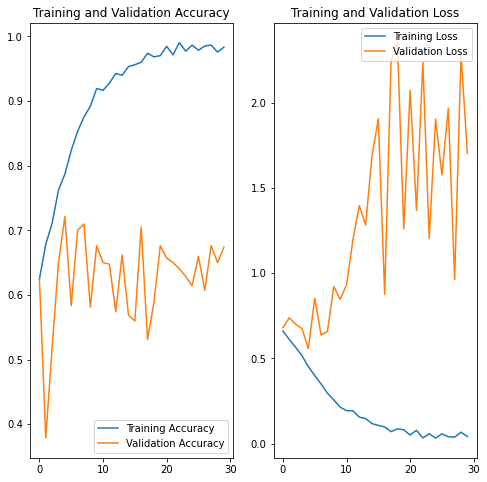

In [195]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Unrepresentative Train Dataset
An unrepresentative training dataset means that the training dataset does not provide sufficient information to learn the problem, relative to the validation dataset used to evaluate it.

This may occur if the training dataset has too few examples as compared to the validation dataset.

This situation can be identified by a learning curve for training loss that shows improvement and similarly a learning curve for validation loss that shows improvement, but a large gap remains between both curves.

- training error: low
- validation error: high
- high variance - low bias

#### Overfitting (aka variance):
A model is said to be overfit if it is over trained on the data such that, it even learns the noise from it. An overfit model learns each and every example so perfectly that it misclassifies an unseen/new example. For a model that’s overfit, we have a perfect/close to perfect training set score while a poor test/validation score.
#### Reasons behind overfitting:
- Using a complex model for a simple problem which picks up the noise from the data.
- Small datasets, as the training set may not be a right representation of the universe.

### Run prediction on a sample image

first image to predict
actual label: Monkeypox
1/1 [==============================] - 0s 340ms/step
predicted label: Monkeypox


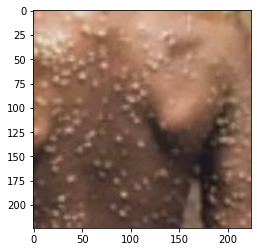

In [196]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [197]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

1/1 [==============================] - 0s 33ms/step


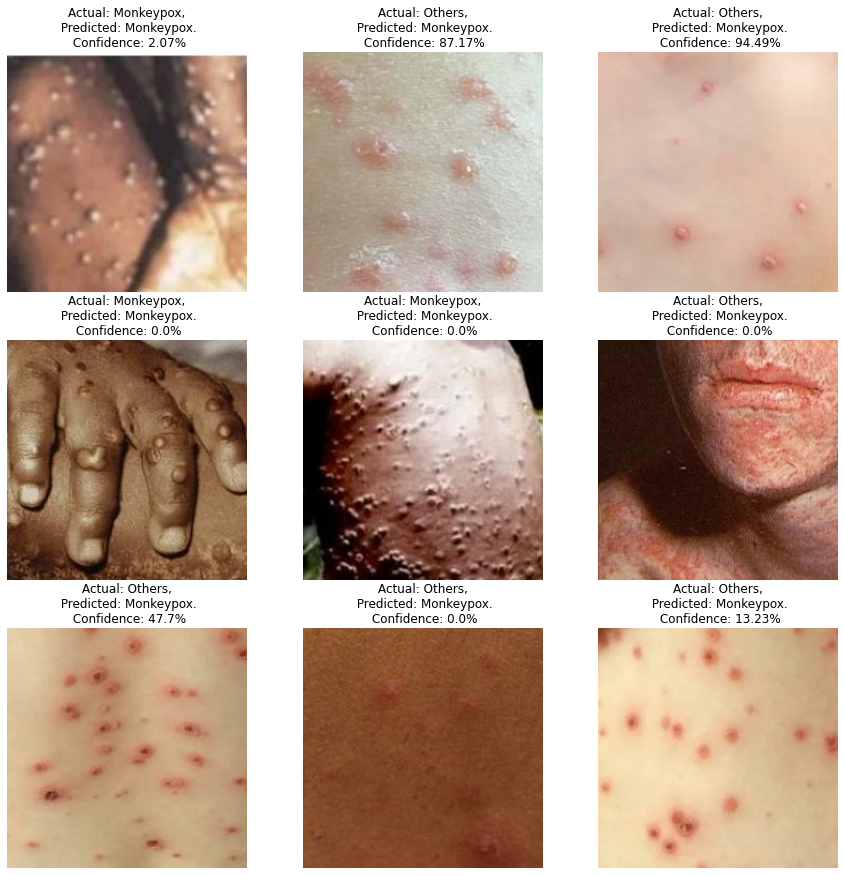

In [198]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [206]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [207]:
model.save("../monkeypox.h5")

In [203]:
print(tf.__version__)

2.9.1
